In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, H_no, E_no, I_no, sub_no, C_syn_e, C_syn_i, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        self.sub_no = sub_no
        self.C_syn_e = C_syn_e
        self.C_syn_i = C_syn_i
        self.E_no = E_no
        self.I_no = I_no
        
        self.E_scale = nn.Parameter(torch.zeros(self.E_no), requires_grad=True)
        self.I_scale = nn.Parameter(torch.zeros(self.I_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
        
        
    def forward(self, S_e, S_i):
        T_data = S_e.shape[1]
        batch_size = S_e.shape[0]
        S_e = S_e * torch.exp(self.E_scale.reshape(1,1,-1))
        S_i = S_i * torch.exp(self.I_scale.reshape(1,1,-1))*(-1)
        
        S_e_sub = torch.matmul(S_e, self.C_syn_e.T.unsqueeze(0))
        S_i_sub = torch.matmul(S_i, self.C_syn_i.T.unsqueeze(0))
        S_sub = S_e_sub + S_i_sub
        
        sub_out = torch.zeros(batch_size, T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            rnn_out, _ = self.rnn[s](S_sub[:,:,s].unsqueeze(2))
            lin_out = self.linear[s](rnn_out.reshape(-1,self.H_no)).reshape(batch_size, T_data)
            sub_out[:,:,s] = sub_out[:,:,s] + lin_out     
        final = torch.sum(sub_out, 2)
        
        return final, sub_out


In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

part_C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")
part_C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_i.npy")
part_C_syn_e = torch.from_numpy(part_C_syn_e)
part_C_syn_i = torch.from_numpy(part_C_syn_i)

In [4]:
T_train = 994 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 10
layer_no = 1
sub_no = 10
E_no = 2000
I_no = 200
device = torch.device("cuda")

batch_length = 50000
batch_size = 7
iter_no = 9940
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_e[:6] = part_C_syn_e

C_syn_i = torch.zeros(sub_no, I_no).to(device)
C_syn_i[:6] = part_C_syn_i

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1

In [7]:
model = GenericGRU(H_no, E_no, I_no, sub_no, C_syn_e, C_syn_i, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.75)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

6210


In [8]:


for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _ = model(batch_E_neural[:,10000:40000], batch_I_neural[:,10000:40000])
    
    loss = torch.mean((V_pred - batch_V[:,10000:40000])**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural[10000:40000].unsqueeze(0), test_I_neural[10000:40000].unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[10000:40000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:40000]-test_V_pred)**2).item()
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-8-de7c31b5f489>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.001542 2.806418
49 0.067861 2.506405
99 0.476383 1.423675
149 0.661402 0.910499
199 0.72996 0.762009
249 0.850086 0.412686
299 0.890196 0.290474
349 0.911251 0.233868
399 0.926411 0.195637
449 0.936055 0.188669
499 0.951404 0.128656
549 0.956566 0.165443
599 0.962859 0.097975
649 0.965327 0.094725
699 0.966708 0.088543
749 0.968604 0.086741
799 0.969356 0.082053
849 0.970989 0.158729
899 0.972773 0.083118
949 0.973756 0.071479
999 0.974747 0.066512
1049 0.975489 0.064912
1099 0.975814 0.063901
1149 0.976358 0.063151
1199 0.977498 0.066933
1249 0.97715 0.066171
1299 0.977709 0.058935
1349 0.978693 0.056163
1399 0.978266 0.059745
1449 0.979187 0.070884
1499 0.979378 0.055804
1549 0.979134 0.059917
1599 0.979893 0.063705
1649 0.979498 0.057811
1699 0.980648 0.051006
1749 0.97995 0.0614
1799 0.980884 0.056694
1849 0.981221 0.050908
1899 0.9808 0.050961
1949 0.981748 0.048164
1999 0.981254 0.073134
2049 0.981057 0.057942
2099 0.98155 0.051321
2149 0.981626 0.06201
2199 0.982129 0.050128

KeyboardInterrupt: 

In [9]:
#.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat.pt")

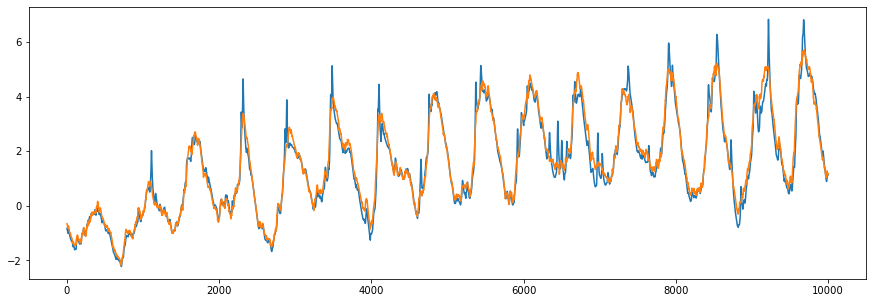

In [22]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000][6000:16000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000])

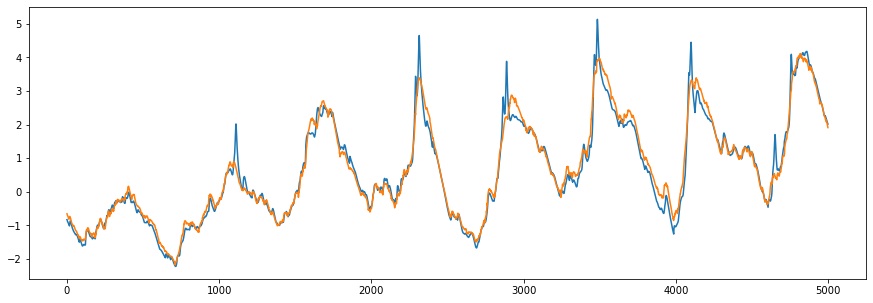

In [23]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000][6000:16000][:5000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000][:5000])

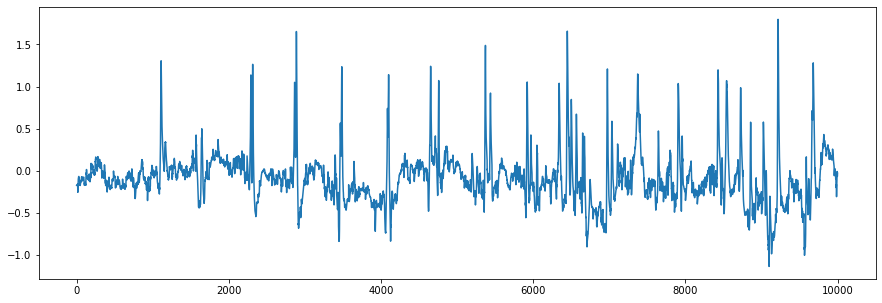

In [24]:
diff = V_test[10000:40000] - test_V_pred

plt.figure(figsize = (15,5))
plt.plot(diff.cpu().detach().numpy()[6000:16000])

In [12]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, C_syn, bias, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_s4_h5_nospat.pt"))
model.eval()
model.cuda()

GenericGRU(
  (rnn): ModuleList(
    (0): GRU(1, 5, batch_first=True)
    (1): GRU(1, 5, batch_first=True)
    (2): GRU(1, 5, batch_first=True)
    (3): GRU(1, 5, batch_first=True)
  )
  (linear): ModuleList(
    (0): Linear(in_features=5, out_features=1, bias=False)
    (1): Linear(in_features=5, out_features=1, bias=False)
    (2): Linear(in_features=5, out_features=1, bias=False)
    (3): Linear(in_features=5, out_features=1, bias=False)
  )
)

In [13]:
temp = 0
test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,e_idx], temp, True)

In [13]:
sub_neural = torch.matmul(test_E_neural[:,e_idx],C_syn.T)
sub_neural = sub_neural.cpu().detach().numpy()
print(sub_neural.shape)

(50000, 4)


Text(0.5, 0.9, 'Subunit 0, H=10')

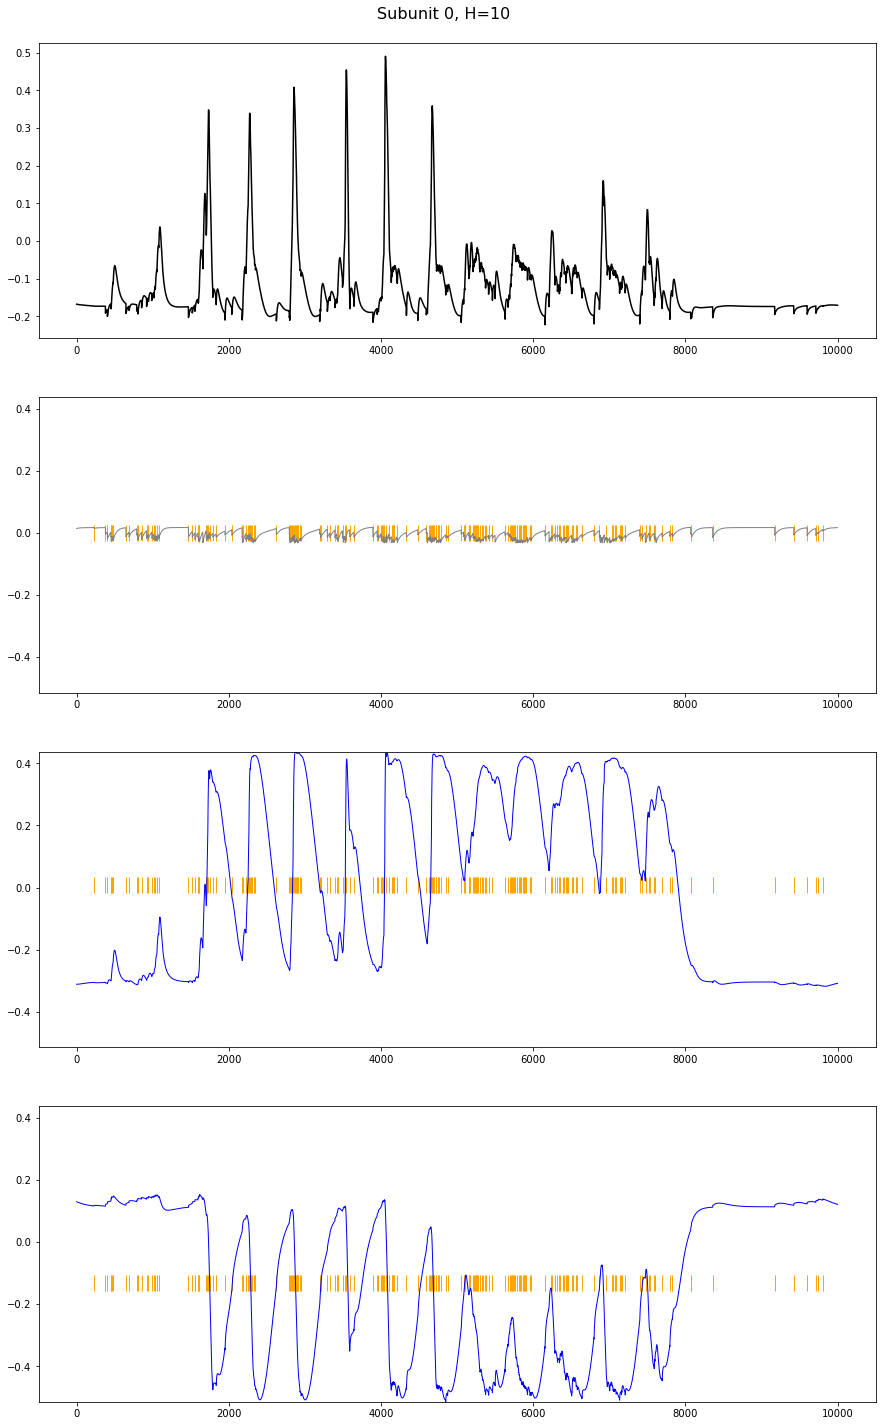

In [14]:
fig, axs = plt.subplots(nrows=H_no+1, figsize = (15,25))

sub = 0

W = model.linear[sub].weight.cpu().detach().numpy().flatten()

total = np.zeros((10000))

min_val = np.min(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)
max_val = np.max(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)

for i in range(H_no):
    mean = np.mean(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    #min_val = np.min(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    #max_val = np.max(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    
    if W[i] >= 0.1:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="red", linewidth=1)
    elif W[i] <= -0.1:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="blue", linewidth=1)
    else:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="gray", linewidth=1)
    
    axs[i+1].scatter(np.arange(10000), sub_neural[16000:26000,sub]-1+mean, marker="|", s=250, color="orange", linewidth=1)
    axs[i+1].set_ylim(min_val, max_val)
    total += test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i]
    
#axs[0].plot(V_test.cpu().detach().numpy()[16000:26000], color="black")
#axs[0].plot(test_V_pred.cpu().detach().numpy()[16000:26000], color="red")
axs[0].plot(total, color="black")
    
fig.suptitle("Subunit "+str(sub)+", H=10", y=0.9, fontsize = 16)
#plt.savefig("/media/hdd01/sklee/CA1_clust4-60/gru_s"+str(sub_no)+"_h"+str(H_no)+"_output_"+str(sub)+".png", dpi=150, bbox_inches='tight')

In [ ]:
for i in range(sub_no):
    print(model.linear[i].weight)